In [ ]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import cloudscraper
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns 

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from google.colab.patches import cv2_imshow
from skimage import io
import cv2
from PIL import Image
import os
import csv

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Activation, BatchNormalization, Dropout, MaxPooling2D

In [ ]:
## API call to get required data 
url = "https://api.opensea.io/api/v1/assets"
punks = []

for i in range(0, 10001):
    querystring = {"token_ids": str(i),
                    "asset_contract_address":"0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb",
                   "order_direction":"desc",
                   "offset":"0",
                   "limit":"20"}
    response = requests.request("GET", url, params=querystring)
    #print(i, end=" ")
    if response.status_code != 200:
        print('error')
        continue
    else: 
        punks.append(response.json()['assets'])

punks_df2 = pd.DataFrame(list(map(lambda x: x[0], punks)))
punks_df2.to_csv('punks.csv')

## Data cleaning

In [ ]:
punks_df  = pd.read_csv("punks.csv")
punks_df_clean = punks_df.drop(["background_color", "image_preview_url", "image_thumbnail_url", "image_original_url",
 "animation_url", "animation_original_url", "description", "permalink", "decimals", "token_metadata", "owner",
 "sell_orders", "creator", "top_bid", "listing_date", "is_presale", "transfer_fee", "transfer_fee_payment_token", "external_link", "collection"], 1)
punks_df_clean = punks_df_clean.drop(punks_df.columns[0], 1)
punks_df_clean['asset_contract'] = punks_df_clean['asset_contract'].apply(lambda x: ast.literal_eval(x)) 
punks_df_clean['created_date'] = punks_df_clean['asset_contract'].apply(lambda x: x['created_date'])
punks_df_clean = punks_df_clean.drop("asset_contract", 1)
no_prices_index = punks_df_clean[punks_df_clean['last_sale'].isnull()].index
print("There are " + str(len(no_prices_index)) + " cryptopunks which have not been sold before, drop these rows")
print("")
punks_df_clean = punks_df_clean.drop(no_prices_index)
punks_df_clean['last_sale'] = punks_df_clean['last_sale'].apply(lambda x: ast.literal_eval(x))
punks_df_clean['payment_token'] = punks_df_clean['last_sale'].apply(lambda x: x['payment_token']['symbol'])
print("transactions are carried out in the following currencies: " + str(punks_df_clean['payment_token'].unique()))
print("proceed to get ETH prices and USD prices of each cryptopunk")
print("")
punks_df_clean = punks_df_clean.drop("payment_token", 1)
punks_df_clean["eth_price"] = punks_df_clean['last_sale'].apply(lambda x: float(x['total_price']))/(10.**18) #prices in wei
punks_df_clean["usd_price"] = punks_df_clean['last_sale'].apply(lambda x: float(x['payment_token']['usd_price'])) * punks_df_clean["eth_price"]
free_punks = punks_df_clean[punks_df_clean['eth_price'] == 0].index
print("upon further inspection there are " + str(len(free_punks)) + " cryptopunks with no prices. We believe that the eth prices may have been so small that the digits were cut off. we will remove those")
print("this leaves us with " + str(len(punks_df_clean)) + " cryptopunks in this dataset")
punks_df_clean = punks_df_clean.drop(free_punks)
punks_df_clean['event_timestamp'] = punks_df_clean['last_sale'].apply(lambda x: x['event_timestamp'])
punks_df_clean = punks_df_clean.drop("last_sale", 1)
punks_df_clean['traits'] = punks_df_clean['traits'].apply(lambda x: ast.literal_eval(x))

def getTraits(lst):
    values = []
    for d in lst:
        if d['value'] not in values:
            values.append(d['value'])
    return values

punks_df_clean['traits'] = punks_df_clean['traits'].apply(lambda x: getTraits(x))
traits_list = []
for index, value in punks_df_clean['traits'].items():
    for trait in value:
        if trait not in traits_list:
            traits_list.append(trait)
d = {}
for trait in traits_list:
    d[trait] = []
    for index, value in punks_df_clean['traits'].items():
        if trait in value:
            d[trait].append(1)
        else:
            d[trait].append(0)
traits_df = pd.DataFrame(d)
traits_df = traits_df.reset_index()
punks_df_clean = punks_df_clean.reset_index()
punks_df_clean = pd.concat([punks_df_clean, traits_df], 1)
punks_df_clean.drop(['created_date', 'traits', 'Male', 'Mohawk'], 1, inplace = True)
punks_df_clean.drop([punks_df_clean.columns[9]], 1, inplace = True)
punks_df_clean.to_csv('punks_cleaned.csv')

## SVM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


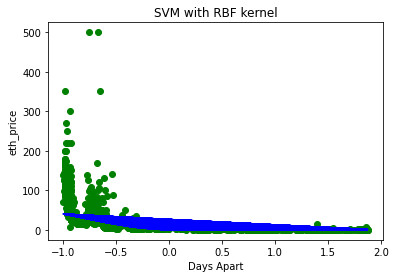

14.372341054736983
1522.9041189106335
39.02440414549124


In [ ]:
punks_df1 = pd.read_csv('punks_cleaned2.csv')
punks_df2 = punks_df1[punks_df1['num_sales'] == 1]

x = np.asarray(punks_df2['Days Apart'])
y = np.asarray(punks_df2['eth_price'])
y = y.reshape(-1,1)
x = x.reshape(-1,1)

sc_x = StandardScaler()
x = sc_x.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y)

regressor = SVR(kernel='rbf')
regressor.fit(x_train,y_train)

plt.scatter(x_train, y_train, color = 'green')
plt.plot(x_train, regressor.predict(x_train), color = 'blue')
plt.title('SVM with RBF kernel')
plt.xlabel('Days Apart')
plt.ylabel('eth_price')
plt.show()

print(mean_absolute_error(y_test, regressor.predict(x_test)))
print(mean_squared_error(y_test, regressor.predict(x_test)))
print(mean_squared_error(y_test, regressor.predict(x_test), squared= False))

## self train CNN

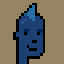

-1

In [ ]:
# Read image from web image
image = io.imread('https://lh3.googleusercontent.com/7bRocEaoBrWYBX3vThkHj4kAV3b3mKG-Kem85xeT-D8oHpvQ19kcoiBd9mIFeNU0GrwZGvj6Oc5NAEGBSsGlrww')
#print(image.shape)
image = cv2.resize(image, (64, 64))
cv2_imshow(image)
cv2.waitKey()

In [ ]:
df = pd.read_csv('/content/sample_data/punks_cleaned.csv')
images = [];
result = []

for ind in df.index:
    try:
        image = io.imread(df['image_url'][ind])
        image = cv2.resize(image, (128, 128))
        images.append(image)
        result.append([image, df['usd_price'][ind]])
    except Exception as e:
        print(e)
        continue

HTTP Error 500: Internal Server Error


In [ ]:
headers = ['image', 'price']
df2 = pd.DataFrame(result, columns = headers)
df2["eth_price"] = df["eth_price"]

images = np.array(images)
images = images / 255.0

In [ ]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.6)(x)
    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model

In [ ]:
split = train_test_split(df2, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
model = create_cnn(128, 128, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["mean_squared_error"])

history = model.fit(x=trainImagesX, y=trainAttrX["eth_price"], 
    validation_data=(testImagesX, testAttrX["eth_price"]),
    epochs=150, batch_size=32) 

preds = model.predict(testImagesX)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
137/137 [==============================] - 96s 694ms/step - loss: 12675.9424 - mean_squared_error: 12675.9424 - val_loss: 17734.5039 - val_mean_squared_error: 17734.5039
Epoch 2/150
137/137 [==============================] - 95s 695ms/step - loss: 12631.1484 - mean_squared_error: 12631.1484 - val_loss: 17723.0234 - val_mean_squared_error: 17723.0234
Epoch 3/150
137/137 [==============================] - 95s 697ms/step - loss: 12614.5840 - mean_squared_error: 12614.5840 - val_loss: 17711.7012 - val_mean_squared_error: 17711.7012
Epoch 4/150
137/137 [==============================] - 95s 697ms/step - loss: 12602.2432 - mean_squared_error: 12602.2432 - val_loss: 17700.5664 - val_mean_squared_error: 17700.5664
Epoch 5/150
137/137 [==============================] - 95s 697ms/step - loss: 12589.8213 - mean_squared_error: 12589.8213 - val_loss: 17689.3770 - val_mean_squared_error: 17689.3770
Epoch 6/150
137/137 [==============================] - 95s 696ms/step - loss: 12577.8350 -

In [ ]:
mse_test = mean_squared_error(testAttrX["eth_price"],preds)
mse_train = mean_squared_error(trainAttrX["eth_price"],model.predict(trainImagesX))
print(mse_test, mse_train) 

#10060.92655631016 59319.02088229264 (dropout=0.25, batch size = 16)
#7246.9532777810455 19080.764081643996 (dropout=0.5, batch size = 16)
#214779.142002418 7696.40690924029 (dropout=0.55, batch size = 16)
#9962.678564979076 9151.075837143515 (dropout=0.6, batch size = 16)
#821491618.3952924 529651068.9911889 (dropout=0.75, batch size = 16)

14303.808223700582 9642.461026797859


In [ ]:
mse = mean_squared_error(df2["eth_price"],model.predict(images))
mae = mean_absolute_error(df2["eth_price"],model.predict(images))
print(mse, mae)

10808.196505868706 39.07358757561597


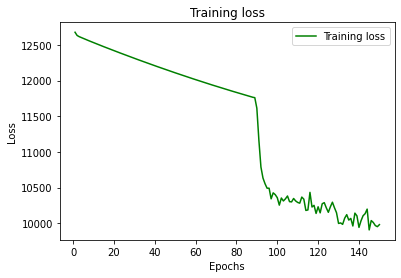

In [ ]:
train_loss = history.history["loss"]
epochs = range(1,151)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

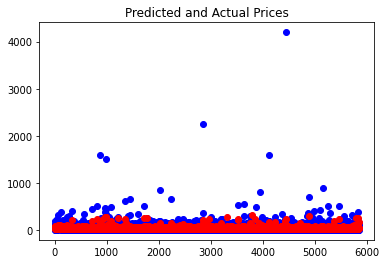

In [ ]:
# plot for training data
ax = plt.gca()
ax.scatter(trainAttrX.index, trainAttrX["eth_price"], color="b", label='actual')
ax.scatter(trainAttrX.index, model.predict(trainImagesX), color="r", label='predicted')
plt.title('Predicted and Actual Prices')
plt.show()

In [ ]:
X = df[['num_sales', 'Smile', 'Female', 'Hot Lipstick','Pipe','Pilot Helmet',
        'Big Shades','Straight Hair','Choker','Black Lipstick','Earring',
        'Clown Eyes Blue','Tiara','Bandana','Peak Spike','Normal Beard Black',
        'Horned Rim Glasses','Stringy Hair','Eye Patch','Do-rag','Chinstrap',
        'Headband','3D Glasses','Beanie','Clown Hair Green','Clown Nose',
        'Purple Lipstick','Pigtails','Frumpy Hair','Blue Eye Shadow',
        'Silver Chain','Blonde Bob','Regular Shades','Wild White Hair',
        'Messy Hair','Mole','Mustache','Crazy Hair','Nerd Glasses',
        'Straight Hair Blonde','Front Beard','Mohawk Thin','Goat','Knitted Cap',
        'Frown','Wild Blonde','Orange Side','Cap Forward','Cap','Handlebars',
        'Eye Mask','Purple Hair','Muttonchops','Dark Hair','Wild Hair','Cigarette',
        'Purple Eye Shadow','Hoodie','Clown Eyes Green','Pink With Hat','Small Shades',
        'Medical Mask','Green Eye Shadow','Normal Beard','Half Shaved','Classic Shades',
        'Shaved Head','Shadow Beard','Buck Teeth','Straight Hair Dark','Top Hat',
        'Big Beard','Front Beard Dark','Mohawk Dark','Cowboy Hat','VR','Vampire Hair',
        'Spots','Fedora','Tassle Hat','Luxurious Beard','Vape','Rosy Cheeks','Red Mohawk',
        'Police Cap','Blonde Short','Gold Chain','Zombie','Welding Goggles','Ape','Alien']]
y = df['eth_price']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3)

regressor = LinearRegression()
regressor.fit(X_train,  y_train) 
print(regressor.intercept_)    
y_pred = regressor.predict(X_test)
pred_out  = pd.DataFrame({'Actual':  y_test, 'Predicted': y_pred})
pred_out

pred_out1  = pred_out.head(20)
pred_out1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major',  linestyle='-', linewidth='0.5',  color='black')
plt.grid(which='minor',  linestyle=':', linewidth='0.5',  color='black')
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
z = list(range(1, 41))
plt.plot(z,test_out1)
plt.plot(z,pred_out1)
plt.show
print(pred_out)

df = pd.read_csv('C:/Users/tobyl/Downloads/punks_cleaned - Copy.csv')
df.plot(x='Days Apart', y='eth_price', style='o')  
plt.title('Price with Days Apart')  
plt.xlabel('Days Apart')  
plt.ylabel('Price')  
plt.show()
x= df['Days Apart']
print(x)

from sklearn.preprocessing import StandardScaler

scale= StandardScaler()
X = df[['Days Apart']]
y = df['eth_price']




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

Re = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
Re

print(X_train)

Re1 = Re.head(25)
Re1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title('Price with Days Apart')  
plt.xlabel('Days Apart')  
plt.ylabel('Price')  
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



## Pre train CNN


In [ ]:
X = []
y = []

dd = {}
count = 0
with open('punks_cleaned.csv') as src_file:
  src_reader = csv.reader(src_file, delimiter=',')
  for row in src_reader:
    if count == 0:
      count += 1
      continue
    price = float(row[6])
    d = {int(row[1]): price}
    dd.update(d)


for file in os.listdir('/content/drive/MyDrive/test'):
  if file.endswith('.jpg'):
    pID = int(file.split('.')[0])
    test_image = file
    img = Image.open(test_image)
    numpydata = asarray(img)
    X.append(numpydata)
    y.append(dd[pID])
    print(count)
    count += 1


X = np.array(X)
y = np.array(y)

# define model
model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(336,336,3),
                   pooling='avg',classes=9,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=['MeanSquaredError'])

checkpoint_path = "/content/drive/MyDrive/Punks_linear/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.load_weights(checkpoint_path)
actl = []
predarr = []
count = []
counter = 0
for file in os.listdir('/content/drive/MyDrive/test'):
  if file.endswith('.jpg'):
    test_image = file
    name = int(file.split('.')[0])
  image=cv2.imread(test_image)
  image_resized= cv2.resize(image, (336,336))
  image=np.expand_dims(image_resized,axis=0)
  pred=model.predict(image)
  actl.append(dd[name])
  predarr.append(pred[0][0])
  count.append(counter)
  counter += 1
  print(counter)

plt.xlabel("Number of Crypto Punks") 
plt.ylabel("Price in Eth")
plt.scatter(count,actl,color='red', label="Actual")
plt.scatter(count,predarr,color='blue', label="Predicted")
plt.legend()
plt.show()

## LR

In [ ]:
from sklearn.linear_model import LinearRegression

mse_train = []
mse_test = []

for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    mod = LinearRegression()
    mod.fit(X_train, y_train)
    y_pred=mod.predict(X_train)
    score = metrics.mean_squared_error(y_train, y_pred)
    mse_train.append(score)
    y_pred_test=mod.predict(X_test)
    score = metrics.mean_squared_error(y_test, y_pred_test)
    mse_test.append(score)

    
print('Avg Training Accuracy:{}'.format(sum(mse_train)/k))
print('Avg Test Accuracy:{}'.format(sum(mse_test)/k))

Avg Training Accuracy:1203.325509135581
Avg Test Accuracy:1450.1616735418318
